# CDK2 protein
# Data load and preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%run ../modules/run_or_load_decorator.py
%run ../modules/plotting_metrics.py

In [2]:
%run ./1_Helper_functions.ipynb

In [3]:
protein_name='cdk2'
file_name = '../6_Machine_Learning_Models/df_DkSc_results_COCRYS_CSAR_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values

## Estimators
### ML Classifiers

In [4]:
from sklearn.neighbors import KNeighborsClassifier

hyparams ={'n_neighbors': 1, 'n_jobs': 4}
knn = KNeighborsClassifier(**hyparams)

In [5]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter':400}
lr = LogisticRegression(**hyparams)

In [6]:
from xgboost import XGBClassifier

hyparams ={'subsample': 0.5, 'n_estimators': 200, 
           'max_depth': 20, 'learning_rate': 0.05, 
           'gamma': 0.01, 'colsample_bytree': 0.5, 'alpha': 0.01}
xgb = XGBClassifier(**hyparams)

In [7]:
# ML Classifier
ml_classifiers = {
    'knn': knn,
    'lr': lr,
    'xgb': xgb,
}

# update names
ml_classifiers = {f'ml_{name}': clf 
                for name, clf in ml_classifiers.items()}

### Consensus Scorings

In [8]:
%run ../6_Machine_Learning_Models/5_Helper_Consensus_Scoring.ipynb

cs_functions = {
    'MEAN': get_mean_score,
    'MAX': get_max_score,
    'MIN': get_min_score,
    'VOTE': get_vote_score
}

# update names
cs_functions = {f'cs_{name}': func 
                for name, func in cs_functions.items()}

### Estimators dictionary 

In [9]:
estimators = {**ml_classifiers, **cs_functions}

### Evaluation metrics 

In [10]:
metrics=dict(roc_auc = {'metric_name': 'roc_auc'},
             nef_02 = {'metric_name': 'ef', 
                    'fraction': 0.02, 'method':'normalized'},
             nef_005 = {'metric_name': 'ef', 
                        
                    'fraction': 0.005, 'method':'normalized'},
             nef_12_Ra = {'metric_name': 'ef', 
                    'fraction': 0.12, 'method':'normalized'}
            )

# Hold-out Validation 

## 30 replicas
### AUC-ROC


In [11]:
# Save the results to a file to ommit repeate the analysis
@run_or_load_joblib
def n_hold_out_validation_SAVE(filename, **kwargs):
    return n_hold_out_validation(**kwargs)

In [12]:
%%time
evaluation_name='ho30'
ho30 = n_hold_out_validation_SAVE(
    filename=f'./cachedir/{evaluation_name}_{protein_name}',
    estimators=estimators, X=X, y=y, metrics=metrics, 
                      n_reps=30, random_state=42)

metric='roc_auc'
# Normality
display(multi_norm_test(ho30, metric=metric))
# Homocedasticity
display(multi_homovar_test(ho30, metric=metric))

File loaded: ./cachedir/ho30_cdk2


,ml_knn,ml_lr,ml_xgb,cs_MEAN,cs_MAX,cs_MIN,cs_VOTE
Normality,1,1,1,1,1,1,1


,statistic,p
Bartlett,37.588723,0.000001


CPU times: user 19.7 ms, sys: 3.13 ms, total: 22.8 ms
Wall time: 20.5 ms


### Statistical Evaluation
#### Multiple classifiers

In [13]:
%run Friedman_and_Nemenyi_test.ipynb

In [14]:
ho30_auc = ho30.loc['roc_auc']

#### Friedman's test

In [15]:
friedmanTest(ho30_auc)

,chi^2,dof,p_value
Friedman Test,167.828571,6,1.298615e-33


In [16]:
friedman_imanDavenportTest(ho30_auc)

,F,dof1,dof2,p_value
Friedman Test,399.873239,6,174,5.607285e-99


#### Nemenyi test - pairwise comparison

In [17]:
display(pairwise_nemenyi(ho30_auc)[0].style.applymap(_col_sig_p_values))

,cs_MAX,cs_MEAN,cs_MIN,cs_VOTE,ml_knn,ml_lr,ml_xgb
cs_MAX,1.000000,0.900000,0.001000,0.861548,0.074042,0.001000,0.001000
cs_MEAN,0.900000,1.000000,0.017553,0.900000,0.001977,0.001000,0.001000
cs_MIN,0.001000,0.017553,1.000000,0.031120,0.001000,0.001000,0.001000
cs_VOTE,0.861548,0.900000,0.031120,1.000000,0.001000,0.001000,0.001000
ml_knn,0.074042,0.001977,0.001000,0.001000,1.000000,0.434893,0.011725
ml_lr,0.001000,0.001000,0.001000,0.001000,0.434893,1.000000,0.756125
ml_xgb,0.001000,0.001000,0.001000,0.001000,0.011725,0.756125,1.000000


### Visualizations

#### Swarm plot

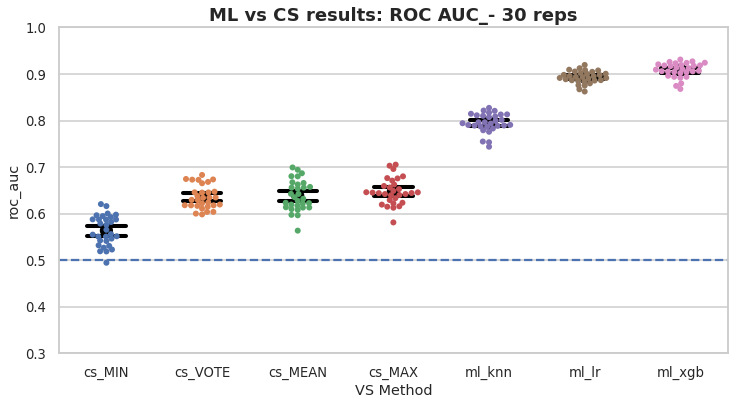

In [18]:
metric='roc_auc'
plot_swarm_metrics(ho30, metric_name=metric, ascending=True, title_extra='- 30 reps')

#### Critical Differences plot

Critical Difference: 3.4044266913143146


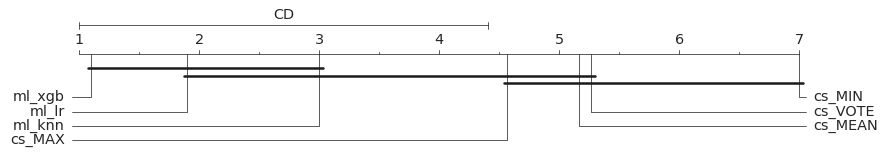

In [19]:
plot_cd(ho30_auc)

#### p-values heatmap

         cs_MAX  cs_MEAN  cs_MIN  cs_VOTE  ml_knn  ml_lr  ml_xgb
cs_MAX     -1.0      0.0     1.0      0.0     0.0    1.0     1.0
cs_MEAN     0.0     -1.0     3.0      0.0     2.0    1.0     1.0
cs_MIN      1.0      3.0    -1.0      3.0     1.0    1.0     1.0
cs_VOTE     0.0      0.0     3.0     -1.0     1.0    1.0     1.0
ml_knn      0.0      2.0     1.0      1.0    -1.0    0.0     3.0
ml_lr       1.0      1.0     1.0      1.0     0.0   -1.0     0.0
ml_xgb      1.0      1.0     1.0      1.0     3.0    0.0    -1.0
-----------


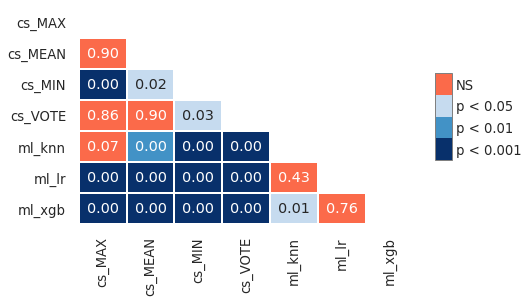

In [20]:
plot_p_heatmap(ho30_auc)

#### Boxplot: Pairwise statistical significance

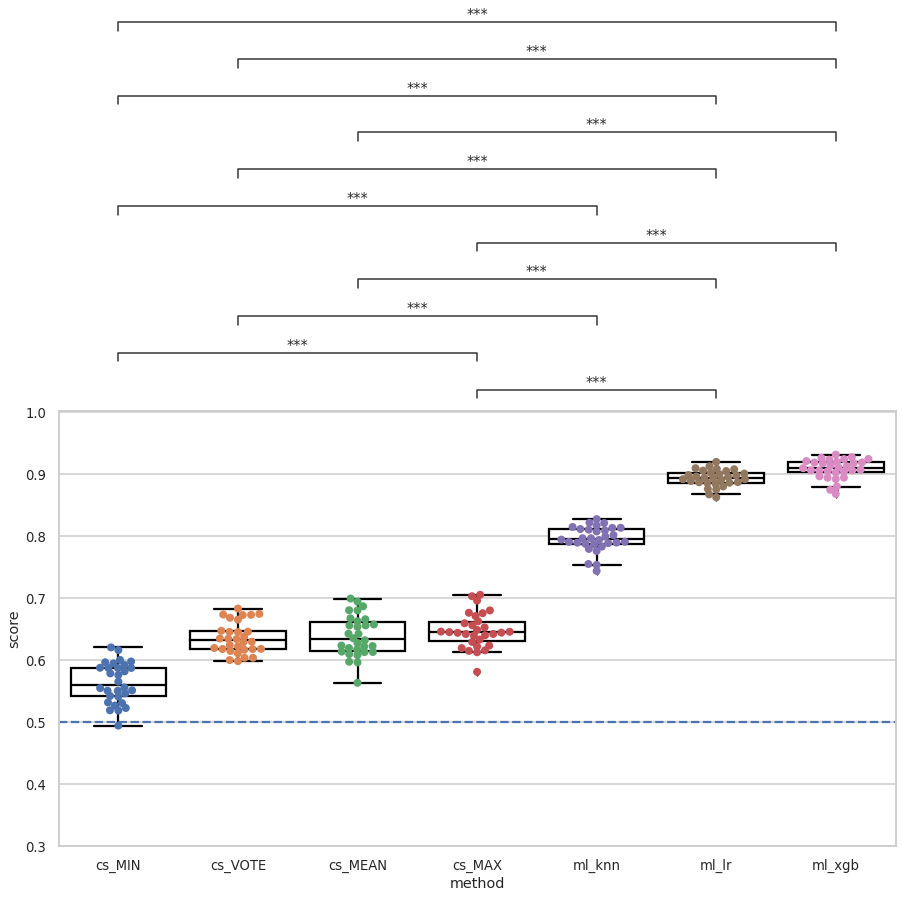

In [21]:
plot_box_signif(ho30, 'roc_auc', ascending=True)

# Y-randomization test

In [22]:
@run_or_load_joblib
def n_hout_val_scrambling(filename, y, random_chi,  **kwargs):
    y_rand = randomize_y_labels(y_target=y, random_chi=random_chi)
    results = n_hold_out_validation(y=y_rand, **kwargs)
    return results

In [ ]:
%%time
chi_fractions = [1, 0.75, 0.5, 0.25, 0.0]
n_reps=30
chi_results = {}
evaluation_name = f'y_scrambling_{n_reps}_reps'

for chi in chi_fractions:
    filename = f'./cachedir/{evaluation_name}_{protein_name}_chi-{chi}'
    result = n_hout_val_scrambling(filename=filename, 
                             random_chi=chi, estimators=estimators, 
                             X=X, y=y, metrics=metrics, 
                             n_reps=n_reps, random_state=42)
    print(f'Fraction chi={chi} finished.')
    chi_results[f'chi_{chi}'] = result
    

/home/ricci/miniconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


File saved: ./cachedir/y_scrambling_30_reps_cdk2_chi-1
Fraction chi=1 finished.


In [ ]:
for chi in chi_results.keys():
    a = chi_results[chi]
    plot_swarm_metrics(a, metric_name=metric, ascending=True, title_extra=f'- chi={chi}')